# Query-by-Example (QbE) Search Using DTW

## Preliminary

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from __future__ import print_function
from os import path
from python_speech_features import delta
from python_speech_features import mfcc
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import sys
import simpleaudio as sa
from pydub import AudioSegment
from pydub.playback import play

sys.path.append("..")
sys.path.append(path.join("..", "utils"))

from speech_dtw import qbe

/home/josh/miniconda3/lib/python3.7/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/home/josh/miniconda3/lib/python3.7/site-packages/pydub/utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


## Extract features

In [5]:
def get_mfcc_dd(wav_fn, cmvn=True):
    """Return the MFCCs with deltas and delta-deltas for a audio file."""
    (rate, signal) = wav.read(wav_fn)
    mfcc_static = mfcc(signal, rate, nfft=1103)
    mfcc_deltas = delta(mfcc_static, 2)
    mfcc_delta_deltas = delta(mfcc_deltas, 2)
    print(mfcc_static.shape, mfcc_deltas.shape, mfcc_delta_deltas.shape)
    features = np.hstack([mfcc_static, mfcc_deltas, mfcc_delta_deltas])
    if cmvn:
        features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    return features

In [6]:
wav_fn = path.join("audio", "word_daiwan.wav")
print("Reading:", wav_fn)
query_mfcc = get_mfcc_dd(wav_fn)
query_wav = AudioSegment.from_file(wav_fn, format="wav")
original_mfcc_list = []
original_wav = []
for wav_fn in sorted(glob.glob(path.join("audio", "original?.wav"))):
    print("Reading:", wav_fn)
    #original_wav.append(sa.WaveObject.from_wave_file(wav_fn))
    original_wav.append(AudioSegment.from_file(wav_fn, format="wav"))
    original_mfcc_list.append(get_mfcc_dd(wav_fn))
respeak_mfcc_list = []
respeak_wav = []
for wav_fn in sorted(glob.glob(path.join("audio", "respeak?.wav"))):
    print("Reading:", wav_fn)
    #respeak_wav.append(sa.WaveObject.from_wave_file(wav_fn))
    respeak_wav.append(AudioSegment.from_file(wav_fn, format="wav"))
    respeak_mfcc_list.append(get_mfcc_dd(wav_fn))

Reading: audio/word_daiwan.wav


FileNotFoundError: [Errno 2] No such file or directory: 'audio/word_daiwan.wav'

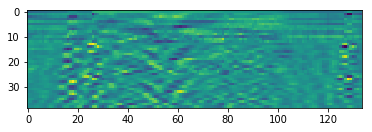

In [5]:
# Plot query
plt.imshow(query_mfcc.T, interpolation="nearest")

## Intermediate analysis

Align query to a search utterance from the same speaker containing the keyword.

Min distance:
Original 0.4210063657529228
Respeak 0.3897449835182462


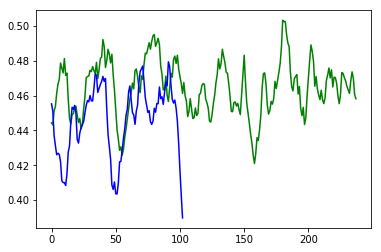

In [6]:
sweep_original = qbe.dtw_sweep(query_mfcc, original_mfcc_list[1])
plt.plot(sweep_original,color='green')
sweep_respeak = qbe.dtw_sweep(query_mfcc, respeak_mfcc_list[1])
plt.plot(sweep_respeak,color='blue')
#print(len(query_mfcc))
print('Min distance:')

#print(len(original_wav[1]))
#print(len(original_mfcc_list[1]))
#print(len(sweep_original))

print('Original ' + str(min(sweep_original)))

#min_original = np.argmin(sweep_original)
#print(min_original)
#print(len(respeak_mfcc_list[1])-len(query_mfcc))
#print(len(sweep_respeak))

print('Respeak ' + str(min(sweep_respeak)))

#print(np.argmin(sweep_respeak))
#print(len(respeak_mfcc_list[1]))
min_respeak = 30*(np.argmin(sweep_respeak))
#print(min_respeak)
#print(len(sweep_respeak))
word_respeak = respeak_wav[1][min_respeak:min_respeak+(5*len(query_mfcc))]
play(query_wav)
play(respeak_wav[1])
#play(word_respeak)
#print(len(query_wav))
#print(len(word_respeak))
#query_wav.play().wait_done()
#original_wav[1].play().wait_done()
#respeak_wav[1].play().wait_done()
#original_word = original_wav[1][]
plt.show()

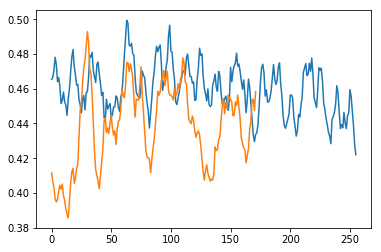

In [7]:
sweep_original = qbe.dtw_sweep(query_mfcc, original_mfcc_list[0])
plt.plot(sweep_original)
sweep_respeak = qbe.dtw_sweep(query_mfcc, respeak_mfcc_list[0])
plt.plot(sweep_respeak)

The minimum aligns with the occurrence of the keyword.

## QbE experiments

Of the four utterances in the search collection, only the utterance `wav/search3.wav` does not contain the keyword. This element corresponds to `search_mfcc_list[2]`.

In [8]:
n_cpus = 3
dtw_costs_original =qbe.parallel_dtw_sweep_min([query_mfcc], original_mfcc_list, n_cpus=n_cpus)
print("DTW costs over original collection:", dtw_costs_original[0])
dtw_costs_respeak = qbe.parallel_dtw_sweep_min([query_mfcc], respeak_mfcc_list, n_cpus=n_cpus)
print("DTW costs over respoken collection:", dtw_costs_respeak[0])

DTW costs over original collection: [0.4220238802424412, 0.4210063657529228, 0.4213601335906261]
DTW costs over respoken collection: [0.3855686543328721, 0.3897449835182462, 0.4102219523203312]


## Take Common English Words

In [37]:
import json# Grab spoken lexicon and return word, crop and duration of the word
json_file = open("english_words/top_100_words.json", "r")
word_dict = json.load(json_file)
word_list = []
for word in word_dict:    
    wav_fn = word["audio"]
    rate, signal = wav.read(wav_fn)
    length = len(signal) / rate * 1000
    query_mfcc = get_mfcc_dd(wav_fn)
    query = {}
    query["length"] = length
    query["data"] = query_mfcc
    query["word"] = word["word"]
    query["audio"] = AudioSegment.from_file(word["audio"], format="wav")
    query["thres"] = 1
    print(query["audio"], end=' ')
    play(query["audio"])
    word_list.append(query)

<pydub.audio_segment.AudioSegment object at 0x000001BEA3C66B38> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66C50> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C667F0> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66EB8> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66278> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66780> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66A90> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66F98> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66710> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66898> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66D68> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66940> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66E48> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66390> <pydub.audio_segment.AudioSegment object at 0x000001BEA3C66828> <pydub.audio_segment.AudioSegment object

In [39]:
play(word_list[99]["audio"])

In [13]:
rudd_original_mfcc_list = []
rudd_original_wav = []
for wav_fn in sorted(glob.glob(path.join("utterances", "rudd-apology_?.wav"))):
    print("Reading:", wav_fn)
    #original_wav.append(sa.WaveObject.from_wave_file(wav_fn))
    rudd_original_wav.append(AudioSegment.from_file(wav_fn, format="wav"))
    rudd_original_mfcc_list.append(get_mfcc_dd(wav_fn))
    
for wav_fn in sorted(glob.glob(path.join("utterances", "rudd-apology_??.wav"))):
    print("Reading:", wav_fn)
    #original_wav.append(sa.WaveObject.from_wave_file(wav_fn))
    rudd_original_wav.append(AudioSegment.from_file(wav_fn, format="wav"))
    rudd_original_mfcc_list.append(get_mfcc_dd(wav_fn))

Reading: utterances\rudd-apology_0.wav
Reading: utterances\rudd-apology_1.wav
Reading: utterances\rudd-apology_2.wav
Reading: utterances\rudd-apology_3.wav
Reading: utterances\rudd-apology_4.wav
Reading: utterances\rudd-apology_5.wav
Reading: utterances\rudd-apology_6.wav
Reading: utterances\rudd-apology_7.wav
Reading: utterances\rudd-apology_8.wav
Reading: utterances\rudd-apology_9.wav
Reading: utterances\rudd-apology_10.wav
Reading: utterances\rudd-apology_11.wav
Reading: utterances\rudd-apology_12.wav
Reading: utterances\rudd-apology_13.wav
Reading: utterances\rudd-apology_14.wav
Reading: utterances\rudd-apology_15.wav
Reading: utterances\rudd-apology_16.wav


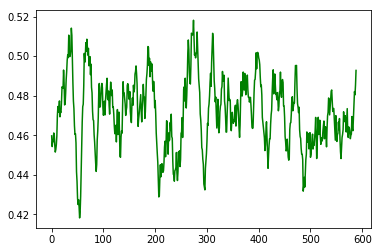

In [43]:
sweep_original = qbe.dtw_sweep(word_list[0]['data'], rudd_original_mfcc_list[0])
plt.plot(sweep_original,color='green')
play(word_list[0]['audio'])
play(rudd_original_wav[0])